# SR3: Explained and Implemented in PyTorch (from scratch)

- Ref: 
    - https://medium.com/@adityanutakki/sr3-explained-and-implemented-in-pytorch-from-scratch-b43b9742c232
    - https://github.com/aditya-nutakki/pfs/tree/master/sr3 


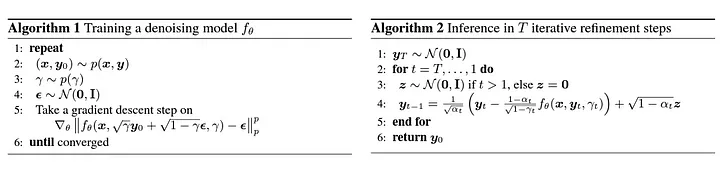

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log

import torchshow
import kagglehub
import os
from pathlib import Path

from torchvision.transforms import InterpolationMode
from torchvision.transforms import transforms
import os, cv2
from torch.utils.data import Dataset, DataLoader
from time import time
from tqdm import tqdm

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)
# device = torch.device("cpu")

Current memory allocated on MPS: 0 bytes
Driver memory allocated on MPS: 393216 bytes
mps


## 1. Setup Network Model

In [3]:
# based on https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py#L34

class GammaEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, dim)
        self.act = nn.LeakyReLU()
    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return self.act(self.linear(encoding))

# Double Conv Block
class conv_block(nn.Module):
    def __init__(self, in_c, out_c, time_steps = 1000, activation = "relu", embedding_dims = None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.embedding_dims = embedding_dims if embedding_dims else out_c

        # self.embedding = nn.Embedding(time_steps, embedding_dim = self.embedding_dims)
        self.embedding = GammaEncoding(self.embedding_dims)
        # switch to nn.Embedding if you want to pass in timestep instead; but note that it should be of dtype torch.long
        self.act = nn.ReLU() if activation == "relu" else nn.SiLU()

    def forward(self, inputs, time = None):
        time_embedding = self.embedding(time).contiguous().reshape(-1, self.embedding_dims, 1, 1)
        # print(f"time embed shape => {time_embedding.shape}")
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = x + time_embedding
        return x

# Encoder Block for downsampling
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c, time_steps, activation = "relu"):
        super().__init__()
        self.conv = conv_block(in_c, out_c, time_steps = time_steps, activation = activation, embedding_dims = out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs, time = None):
        x = self.conv(inputs, time)
        p = self.pool(x)
        return x, p

# Decoder Block for upsampling
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, time_steps, activation = "relu"):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c, time_steps = time_steps, activation = activation, embedding_dims = out_c)
    def forward(self, inputs, skip, time = None):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x, time)
        return x



class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dims, num_heads = 4) -> None:
        super().__init__()
        self.embedding_dims = embedding_dims
        self.num_heads = num_heads
        assert self.embedding_dims % self.num_heads == 0, f"{self.embedding_dims} not divisible by {self.num_heads}"
        self.head_dim = self.embedding_dims // self.num_heads
        self.wq = nn.Linear(self.head_dim, self.head_dim)
        self.wk = nn.Linear(self.head_dim, self.head_dim)
        self.wv = nn.Linear(self.head_dim, self.head_dim)
        self.wo = nn.Linear(self.embedding_dims, self.embedding_dims)

    def attention(self, q, k, v):
        # no need for a mask
        attn_weights = F.softmax((q @ k.transpose(-1, -2))/self.head_dim**0.5, dim = -1)
        return attn_weights, attn_weights @ v

    def forward(self, q, k, v):
        bs, img_sz, c = q.shape
        q = q.contiguous().reshape(bs, img_sz, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.contiguous().reshape(bs, img_sz, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.contiguous().reshape(bs, img_sz, self.num_heads, self.head_dim).transpose(1, 2)
        # q, k, v of the shape (bs, self.num_heads, img_sz**2, self.head_dim)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        attn_weights, o = self.attention(q, k, v) # of shape (bs, num_heads, img_sz**2, c)

        o = o.transpose(1, 2).contiguous().reshape(bs, img_sz, self.embedding_dims)
        o = self.wo(o)
        return attn_weights, o

class AttnBlock(nn.Module):
    def __init__(self, embedding_dims, num_heads = 4) -> None:
        super().__init__()

        self.embedding_dims = embedding_dims
        self.ln = nn.LayerNorm(embedding_dims)
        self.mhsa = MultiHeadSelfAttention(embedding_dims = embedding_dims, num_heads = num_heads)
        self.ff = nn.Sequential(
            nn.LayerNorm(self.embedding_dims),
            nn.Linear(self.embedding_dims, self.embedding_dims),
            nn.GELU(),
            nn.Linear(self.embedding_dims, self.embedding_dims),
        )
    def forward(self, x):
        bs, c, sz, _ = x.shape
        x = x.contiguous().reshape(-1, self.embedding_dims, sz * sz).swapaxes(1, 2) # is of the shape (bs, sz**2, self.embedding_dims)
        x_ln = self.ln(x)
        _, attention_value = self.mhsa(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).contiguous().reshape(-1, c, sz, sz)



In [4]:
class UNet(nn.Module):
    def __init__(self, input_channels = 3, output_channels = 3, time_steps = 512):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.time_steps = time_steps
        self.time_steps = time_steps

        self.e1 = encoder_block(self.input_channels, 64, time_steps=self.time_steps)
        self.e2 = encoder_block(64, 128, time_steps=self.time_steps)
        # self.da2 = AttnBlock(128)
        self.e3 = encoder_block(128, 256, time_steps=self.time_steps)
        self.da3 = AttnBlock(256)
        self.e4 = encoder_block(256, 512, time_steps=self.time_steps)
        self.da4 = AttnBlock(512)

        self.b = conv_block(512, 1024, time_steps=self.time_steps) # bottleneck
        self.ba1 = AttnBlock(1024)
        self.d1 = decoder_block(1024, 512, time_steps=self.time_steps)
        self.ua1 = AttnBlock(512)
        self.d2 = decoder_block(512, 256, time_steps=self.time_steps)
        self.ua2 = AttnBlock(256)
        self.d3 = decoder_block(256, 128, time_steps=self.time_steps)
        # self.ua3 = AttnBlock(128)
        self.d4 = decoder_block(128, 64, time_steps=self.time_steps)
        # self.ua4 = AttnBlock(64)
        self.outputs = nn.Conv2d(64, self.output_channels, kernel_size=1, padding=0)

    def forward(self, inputs, t = None):
        # downsampling block
        s1, p1 = self.e1(inputs, t)
        s2, p2 = self.e2(p1, t)
        s3, p3 = self.e3(p2, t)
        p3 = self.da3(p3)
        s4, p4 = self.e4(p3, t)
        p4 = self.da4(p4)
        # bottleneck
        b = self.b(p4, t)
        b = self.ba1(b)
        # upsampling block
        d1 = self.d1(b, s4, t)
        d1 = self.ua1(d1)
        d2 = self.d2(d1, s3, t)
        d2 = self.ua2(d2)
        d3 = self.d3(d2, s2, t)
        d4 = self.d4(d3, s1, t)
        outputs = self.outputs(d4)
        return outputs

In [5]:
class DiffusionModel(nn.Module):
    def __init__(self, time_steps,
                 beta_start = 10e-4,
                 beta_end = 0.02,
                 image_dims = (3, 128, 128)):

        super().__init__()
        self.time_steps = time_steps
        self.image_dims = image_dims
        c, h, w = self.image_dims
        self.img_size, self.input_channels = h, c
        self.betas = torch.linspace(beta_start, beta_end, self.time_steps)
        self.alphas = 1 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim = -1)
        self.model = UNet(input_channels = 2*c, output_channels = c, time_steps = self.time_steps)

    def add_noise(self, x, ts):
        # 'x' and 'ts' are expected to be batched
        noise = torch.randn_like(x)
        # print(x.shape, noise.shape)
        noised_examples = []
        for i, t in enumerate(ts):
            alpha_hat_t = self.alpha_hats[t]
            noised_examples.append(torch.sqrt(alpha_hat_t)*x[i] + torch.sqrt(1 - alpha_hat_t)*noise[i])
        return torch.stack(noised_examples), noise

    def forward(self, x, t):
        return self.model(x, t)

## 2. Data

In [6]:
# Download latest version
download_dir = kagglehub.dataset_download("heyitsfahd/nature")
print(download_dir)

img_base_dir = os.path.join(download_dir, "Nature", "x128")
classes = os.listdir(img_base_dir)
print(classes)

train_img_fpath_lst = []
val_img_fpath_lst = []
for c in classes:
    img_dir = os.path.join(img_base_dir, c)
    img_fnames = os.listdir(img_dir)
    t_num = len(img_fnames)
    print(f"class - {c} : {t_num} images")
    for i, img_fn in enumerate(img_fnames):
        _img_f_p = os.path.join(img_dir, img_fn)
        if i < 0.95 * t_num:
            train_img_fpath_lst.append(_img_f_p)
        else:
            val_img_fpath_lst.append(_img_f_p)
    # for img_fn in img_fnames:
    #     img_fpath_lst.append(os.path.join(img_dir, img_fn))

print(f"total # of training images : {len(train_img_fpath_lst)}")
print(f"total # of validation images : {len(val_img_fpath_lst)}")



/Users/hyunjae.k/.cache/kagglehub/datasets/heyitsfahd/nature/versions/1
['City', 'Lake', 'Fire', 'Mountain']
class - City : 25318 images
class - Lake : 25236 images
class - Fire : 25423 images
class - Mountain : 24992 images
total # of training images : 95923
total # of validation images : 5046


In [7]:
class SRDataset(Dataset):
    def __init__(self, img_fpath_lst, limit = -1, _transforms = None, hr_sz = 128, lr_sz = 32) -> None:
        super().__init__()

        self.transforms = _transforms

        if not self.transforms:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p = 0.5),
                transforms.ColorJitter([0.5, 1]),
                transforms.RandomAdjustSharpness(1.1, p = 0.4),
                transforms.Normalize((0.5, ), (0.5,)) # normalizing image with mean, std = 0.5, 0.5
            ])
        self.hr_sz = transforms.Resize((hr_sz, hr_sz), interpolation=InterpolationMode.BICUBIC)
        self.lr_sz = transforms.Resize((lr_sz, lr_sz), interpolation=InterpolationMode.BICUBIC)

        # self.dataset_path, self.limit = dataset_path, limit
        # self.valid_extensions = ["jpg", "jpeg", "png", "JPEG", "JPG"]

        # self.images_path = dataset_path
        # self.images = os.listdir(self.images_path)[:self.limit]
        # self.images = [os.path.join(self.images_path, image) for image in self.images if image.split(".")[-1] in self.valid_extensions]
        self.images = img_fpath_lst



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image)
        hr_image, lr_image = self.hr_sz(image), self.lr_sz(image)
        # the core idea here is resizing the (128, 128) down to a lower resolution and then back up to (128, 128)
        return self.hr_sz(lr_image), hr_image # the hr_image is 'y' and low res image scaled to (128, 128) is our 'x'

In [8]:
def sample(model, lr_img, device = "cuda", save_fig = False):
    # lr_img is expected to be batched
    # set to eval mode
    print(f"sample function")
    model.to(device)
    model.eval()

    stime = time()
    print(f"sample Start{stime}")
    with torch.no_grad():

        y = torch.randn_like(lr_img, device = device)
        lr_img = lr_img.to(device)
        for i, t in tqdm(enumerate(range(model.time_steps - 1, 0 , -1))):
            alpha_t, alpha_t_hat, beta_t = model.alphas[t], model.alpha_hats[t], model.betas[t]

            t = torch.tensor(t, device = device).long()
            pred_noise = model(torch.cat([lr_img, y], dim = 1), alpha_t_hat.contiguous().reshape(-1).to(device))
            y = (torch.sqrt(1/alpha_t))*(y - (1-alpha_t)/torch.sqrt(1 - alpha_t_hat) * pred_noise)
            if t > 1:
                noise = torch.randn_like(y)
                y = y + torch.sqrt(beta_t) * noise

    ftime = time()
    print(f"sample Start{ftime}")
    if save_fig:
        torchshow.save(y, f"./temp/sr_sample.jpeg")
    print(f"Done denoising in {ftime - stime}s ")
    return y

In [9]:
# network hyperparameters
time_steps = 2000
epochs = 20
batch_size = 32 #16
image_dims = (3, 128, 128)
low_res_dims = (3, 32, 32)

ddpm = DiffusionModel(time_steps = time_steps)
c, hr_sz, _ = image_dims
_, lr_sz, _ = low_res_dims

ds = SRDataset(train_img_fpath_lst, hr_sz = hr_sz, lr_sz = lr_sz)
loader = DataLoader(ds, batch_size = batch_size, shuffle = True, drop_last = True)

opt = torch.optim.Adam(ddpm.model.parameters(), lr = 1e-3)
criterion = nn.MSELoss(reduction="mean")

ddpm.model.to(device)
Path("./temp/model").mkdir(exist_ok = True, parents=True)
print()
for ep in range(epochs):
    ddpm.model.train()
    print(f"Epoch {ep}:")
    losses = []
    stime = time()

    # for i, (x, y) in tqdm(enumerate(loader), total = len(loader), desc="Processing data"):
    tq = tqdm(enumerate(loader), total = len(loader), desc="Processing data")
    for i, (x, y) in tq:

        # 'y' represents the high-resolution target image, while 'x' represents the low-resolution image to be conditioned upon.

        bs = y.shape[0]
        x, y = x.to(device), y.to(device)
        # print("-----", bs)

        ts = torch.randint(low = 1, high = ddpm.time_steps, size = (bs, ))
        gamma = ddpm.alpha_hats[ts].to(device)
        ts = ts.to(device = device)

        y, target_noise = ddpm.add_noise(y, ts)
        y = torch.cat([x, y], dim = 1)

        predicted_noise = ddpm.model(y, gamma)
        loss = criterion(target_noise, predicted_noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

        # ddpm.model.eval()
        # y_pred = sample(ddpm, x, device)
        # torchshow.show(y_pred)
        # print(f"Loss: {loss.item()}; step {i}; epoch {ep}")
        # ddpm.model.train()
        tq.set_description(f"Loss: {loss.item():.5f}; step {i}; epoch {ep}")

        # if i % 100 == 0:
        #     print(f"Loss: {loss.item()}; step {i}; epoch {ep}")

    ftime = time()
    print(f"Epoch trained in {ftime - stime}s; Avg loss => {sum(losses)/len(losses)}")

    torch.save(ddpm.state_dict(), f"./temp/model/sr_ep_{ep}.pt")


Epoch 0:


Loss: 0.00726; step 2996; epoch 0: 100%|██████████| 2997/2997 [27:23<00:00,  1.82it/s]


Epoch trained in 1643.8085627555847s; Avg loss => 0.01466709683856824
Epoch 1:


Loss: 0.00962; step 2996; epoch 1: 100%|██████████| 2997/2997 [27:56<00:00,  1.79it/s]


Epoch trained in 1676.6972470283508s; Avg loss => 0.006859930141117022
Epoch 2:


Loss: 0.00333; step 2996; epoch 2: 100%|██████████| 2997/2997 [27:36<00:00,  1.81it/s]


Epoch trained in 1656.763284444809s; Avg loss => 0.005744299166733297
Epoch 3:


Loss: 0.00328; step 2996; epoch 3: 100%|██████████| 2997/2997 [27:41<00:00,  1.80it/s]


Epoch trained in 1661.2345340251923s; Avg loss => 0.005344682664028252
Epoch 4:


Loss: 0.00158; step 2996; epoch 4: 100%|██████████| 2997/2997 [27:29<00:00,  1.82it/s]


Epoch trained in 1649.4833979606628s; Avg loss => 0.004954500788090017
Epoch 5:


Loss: 0.00247; step 2996; epoch 5: 100%|██████████| 2997/2997 [27:26<00:00,  1.82it/s]


Epoch trained in 1646.113601922989s; Avg loss => 0.004571098893629757
Epoch 6:


Loss: 0.00551; step 2996; epoch 6: 100%|██████████| 2997/2997 [27:03<00:00,  1.85it/s]


Epoch trained in 1623.8092730045319s; Avg loss => 0.004310332666948148
Epoch 7:


Loss: 0.00253; step 2996; epoch 7: 100%|██████████| 2997/2997 [26:43<00:00,  1.87it/s]


Epoch trained in 1603.465333223343s; Avg loss => 0.0040622591732645055
Epoch 8:


Loss: 0.00938; step 2996; epoch 8: 100%|██████████| 2997/2997 [27:22<00:00,  1.82it/s]


Epoch trained in 1642.2918031215668s; Avg loss => 0.003973880328987232
Epoch 9:


Loss: 0.00259; step 2996; epoch 9: 100%|██████████| 2997/2997 [27:41<00:00,  1.80it/s]


Epoch trained in 1661.6593871116638s; Avg loss => 0.0038806662487817327
Epoch 10:


Loss: 0.00549; step 2996; epoch 10: 100%|██████████| 2997/2997 [26:21<00:00,  1.90it/s]


Epoch trained in 1581.1411669254303s; Avg loss => 0.003723717944279051
Epoch 11:


Loss: 0.00385; step 2996; epoch 11: 100%|██████████| 2997/2997 [25:58<00:00,  1.92it/s]


Epoch trained in 1558.7371892929077s; Avg loss => 0.0036269145757903045
Epoch 12:


Loss: 0.00379; step 2996; epoch 12: 100%|██████████| 2997/2997 [25:23<00:00,  1.97it/s]


Epoch trained in 1523.8343570232391s; Avg loss => 0.0035503545813027845
Epoch 13:


Loss: 0.00483; step 2996; epoch 13: 100%|██████████| 2997/2997 [24:15<00:00,  2.06it/s]


Epoch trained in 1455.5046348571777s; Avg loss => 0.0035270032303587715
Epoch 14:


Loss: 0.00267; step 2996; epoch 14: 100%|██████████| 2997/2997 [24:43<00:00,  2.02it/s]


Epoch trained in 1483.919420003891s; Avg loss => 0.0034019804690183135
Epoch 15:


Loss: 0.00197; step 2996; epoch 15: 100%|██████████| 2997/2997 [24:47<00:00,  2.01it/s]


Epoch trained in 1487.531023979187s; Avg loss => 0.0034314798498192934
Epoch 16:


Loss: 0.00195; step 2996; epoch 16: 100%|██████████| 2997/2997 [24:39<00:00,  2.03it/s]


Epoch trained in 1479.16166305542s; Avg loss => 0.0033484994256439346
Epoch 17:


Loss: 0.00221; step 2996; epoch 17: 100%|██████████| 2997/2997 [24:45<00:00,  2.02it/s]


Epoch trained in 1485.7794847488403s; Avg loss => 0.003258823745543029
Epoch 18:


Loss: 0.00396; step 2996; epoch 18: 100%|██████████| 2997/2997 [24:43<00:00,  2.02it/s]


Epoch trained in 1483.2497730255127s; Avg loss => 0.0033152507594025244
Epoch 19:


Loss: 0.00148; step 2996; epoch 19: 100%|██████████| 2997/2997 [24:40<00:00,  2.02it/s]


Epoch trained in 1480.5216581821442s; Avg loss => 0.003202172648921049


In [10]:

torch.save(ddpm.state_dict(), f"./temp/model/sr_{ep}.pt")
torch.save(ddpm.model.state_dict(), f"./temp/model/sr_model_{ep}.pt")

In [11]:
val_ds = SRDataset(val_img_fpath_lst, hr_sz = hr_sz, lr_sz = lr_sz)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = True, drop_last = True)

In [12]:
valx, valy = next(iter(val_loader))

In [13]:
valy_pred = sample(ddpm, valx, device)

sample function
sample Start1759398096.247262


1999it [04:21,  7.65it/s]

sample Start1759398357.4294772
Done denoising in 261.18221521377563s 


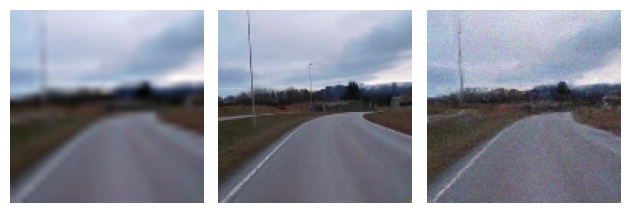

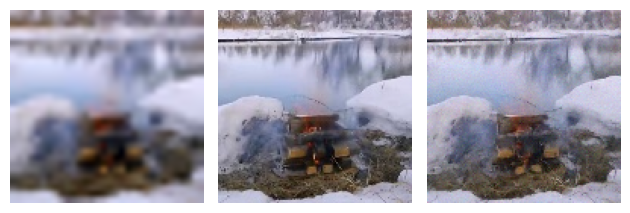

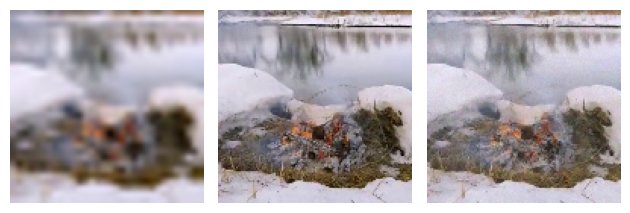

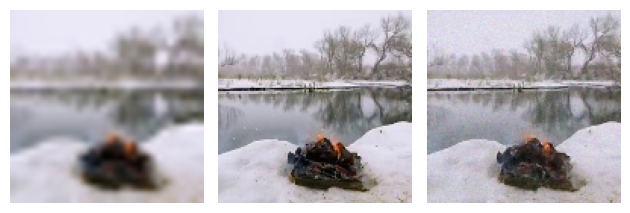

In [16]:
for i in range(4):
    torchshow.show([valx[i], valy[i], valy_pred[i]])